## NLP for Task Classification

**Hypothesis**: Part of Speech (POS) tagging and syntactic dependency parsing provides valuable information for classifying imperative phrases. The thinking is that being able to detect imperative phrases will transfer well to detecting tasks and to-dos.

#### Some Terminology
- [_Imperative mood_](https://en.wikipedia.org/wiki/Imperative_mood) is "used principally for ordering, requesting or advising the listener to do (or not to do) something... also often used for giving instructions as to how to perform a task."
- _Part of speech (POS)_ is a way of categorizing a word based on its syntactic function.
    - The POS tagger from Spacy.io that is used in this notebook differentiates between [*pos_* and *tag_*](https://spacy.io/docs/api/annotation#pos-tagging-english) - *POS (pos_)* refers to "coarse-grained part-of-speech" like `VERB`, `ADJ`, or `PUNCT`; and *POSTAG (tag_)* refers to "fine-grained part-of-speech" like `VB`, `JJ`, or `.`.
- _Syntactic dependency parsing_ is a way of connecting words based on syntactic relationships, [such as](https://spacy.io/docs/api/annotation#dependency-parsing-english) `DOBJ` (direct object), `PREP` (prepositional modifier), or `POBJ` (object of preposition).
    - Check out the dependency parse of the phrase ["Send the report to Kyle by tomorrow"](https://demos.explosion.ai/displacy/?text=Send%20the%20report%20to%20Kyle%20by%20tomorrow&model=en&cpu=1&cph=1) as an example.

### Proposed Features
The imperative mood centers around _actions_, and actions are generally represented in English using verbs. So the features are engineered to also center on the VERB:
1. `FeatureName.VERB`: Does the phrase contain `VERB`(s) of the tag form `VB*`?
2. `FeatureName.FOLLOWING_POS`: Are the words following the `VERB`(s) of certain parts of speech?
3. `FeatureName.FOLLOWING_POSTAG`: Are the words following the `VERB`(s) of certain POS tags?
4. `FeatureName.CHILD_DEP`: Are the `VERB`(s) parents of certain syntactic dependencies?
5. `FeatureName.PARENT_DEP`: Are the `VERB`(s) children of certain syntactic dependencies?
6. `FeatureName.CHILD_POS`: Are the syntactic dependencies that the `VERB`(s) are children of of certain parts of speech?
7. `FeatureName.CHILD_POSTAG`: Are the syntactic dependencies that the `VERB`(s) are children of of certain POS tags?
8. `FeatureName.PARENT_POS`: Are the syntactic dependencies that the `VERB`(s) parent of certain parts of speech?
9. `FeatureName.PARENT_POSTAG`: Are the syntactic dependencies that the `VERB`(s) parent of certain POS tags?

**Notes:**
- Features 2-9 all depend on feature 1 between `True`; if `False`, phrase vectorization will result in all zeroes.
- When features 2-9 are applied to actual phrases, they will append identifying informating about the feature in the form of `_*` (e.g., `FeatureName.FOLLOWING_POSTAG_WRB`).

## Data and Setup

### Building a recipe corpus

I wrote and ran `epicurious_recipes.py`\* to scrape Epicurious.com for recipe instructions and descriptions. I then performed some manual cleanup of the script results. Output is in `epicurious-pos.txt` and `epicurious-neg.txt`.

\* _script (very) loosely based off of https://github.com/benosment/hrecipe-parse_

**Note** that deriving all negative examples in the training set from Epicurious recipe descriptions would result in negative examples that are longer and syntactically more complicated than the positive examples. This is a form of bias.

To (hopefully?) correct for this a bit, I will add the short movie reviews found at https://pythonprogramming.net/static/downloads/short_reviews/ as more negative examples.

This still feels weird because we're selecting negative examples only from specific categories of text (recipe descriptions, short movie reviews) - just because they're readily available. Further, most positive examples are recipe instructions - also a specific (and not necessarily related to the main "task" category) category of text.

Ultimately though, this recipe corpus is a **stopgap/proof of concept** for a corpus more relevant to tasks later on, so I won't worry further about this for now.

In [1]:
import os
from numpy import random

In [2]:
BASE_DIR = os.getcwd()
pos_data_path = BASE_DIR + '/pos.txt'
neg_data_path = BASE_DIR + '/neg.txt'

In [3]:
with open(pos_data_path, 'r', encoding='utf-8') as f:
    pos_data = f.read()
with open(neg_data_path, 'r', encoding='utf-8') as f:
    neg_data = f.read()

In [4]:
pos_data_split = pos_data.split('\n')
neg_data_split = neg_data.split('\n')

num_pos = len(pos_data_split)
num_neg = len(neg_data_split)

# 50/50 split between the number of positive and negative samples
num = num_pos if num_pos < num_neg else num_neg

# shuffle samples
random.shuffle(pos_data_split)
random.shuffle(neg_data_split)

In [5]:
lines = []
for l in pos_data_split[:num]:
    lines.append((l, 'pos'))
for l in neg_data_split[:num]:
    lines.append((l, 'neg'))

In [6]:
# Features as defined in the introduction
from enum import Enum, auto
class FeatureName(Enum):
    VERB = auto()
    FOLLOWING_POS = auto()
    FOLLOWING_POSTAG = auto()
    CHILD_DEP = auto()
    PARENT_DEP = auto()
    CHILD_POS = auto()
    CHILD_POSTAG = auto()
    PARENT_POS = auto()
    PARENT_POSTAG = auto()

## [spaCy.io](https://spacy.io/) for NLP
_Because Stanford CoreNLP is hard to install for Python_

Found Spacy through an article on ["Training a Classifier for Relation Extraction from Medical Literature"](https://www.microsoft.com/developerblog/2016/09/13/training-a-classifier-for-relation-extraction-from-medical-literature/) ([GitHub](https://github.com/CatalystCode/corpus-to-graph-ml))

<img src="nltk_library_comparison.png" alt="NLTK library comparison chart https://spacy.io/docs/api/#comparison" style="width: 400px; margin: 0;"/>

In [7]:
#!conda config --add channels conda-forge
#!conda install spacy
#!python -m spacy download en

### Using the Spacy Data Model for NLP

In [8]:
import spacy
nlp = spacy.load('en')

Spacy's sentence segmentation is lacking... https://github.com/explosion/spaCy/issues/235. So each '\n' will start a new Spacy Doc.

In [9]:
def create_spacy_docs(ll):
    dd = [(nlp(l[0]), l[1]) for l in ll]
    # collapse noun phrases into single compounds
    for d in dd:
        for np in d[0].noun_chunks:
            np.merge(np.root.tag_, np.text, np.root.ent_type_)
    return dd

In [10]:
docs = create_spacy_docs(lines)

### NLP output

Tokenization, POS tagging, and dependency parsing happened automatically with the `nlp(line)` calls above! So let's look at the outputs.

https://spacy.io/docs/usage/data-model and https://spacy.io/docs/api/doc will be useful going forward

In [11]:
for doc in docs[:10]:
    print(list(doc[0].sents))

[Add tofu and gently toss; set aside to marinate.]
[Scatter cheese on top. Finely grate some lemon zest over salad, then slice open lemon and squeeze on some juice.]
[Toss zucchini, vinegar, chopped oregano, and 1/4 cup oil in a medium bowl to combine; season zucchini salsa with salt and pepper.]
[Berry syrup can be made 3 days ahead.]
[Cook, stirring continuously and occasionally scraping the bottom of the pan with the wooden spoon, until the mixture has thickened and coats the spoon with little to no transparency.]
[Remove seeds from remaining 2 tomatoes and cut into 1/4" cubes.]
[Transfer to a cutting board and let cool slightly.]
[Combine grated garlic, lemon juice, and a pinch of salt in a food processor and let sit until the bite in garlic mellows, about 5 minutes.]
[Mix at low speed just until the ingredients come together, about 1 minute.]
[Serve or freeze in an airtight container for up to a week.]


In [12]:
for doc in docs[:10]:
    print(list(doc[0].noun_chunks))

[tofu]
[cheese, top, some lemon zest, salad, some juice]
[zucchini, vinegar, oregano, 1/4 cup oil, a medium bowl, salt, pepper]
[Berry syrup]
[Cook, the bottom, the pan, the wooden spoon, the mixture, the spoon, no transparency]
[seeds, 2 tomatoes, 1/4" cubes]
[Transfer, a cutting board]
[garlic, lemon juice, a pinch, salt, a food processor, the bite, garlic mellows]
[Mix, low speed, the ingredients]
[Serve, freeze, an airtight container]


[Spacy's dependency graph visualization](https://demos.explosion.ai/displacy)

In [13]:
for doc in docs[:5]:
    for token in doc[0]:
        print(token.text, token.dep_, token.lemma_, token.pos_, token.tag_, token.head, list(token.children))

Add ROOT add VERB VB Add [tofu, toss, .]
tofu dobj tofu NOUN NN Add [and]
and cc and CCONJ CC tofu []
gently advmod gently ADV RB toss []
toss conj toss VERB VB Add [gently, ;, set]
; punct ; PUNCT : toss []
set acl set VERB VBN toss [aside, marinate]
aside advmod aside ADV RB set []
to aux to PART TO marinate []
marinate advcl marinate VERB VB set [to]
. punct . PUNCT . Add []
Scatter ROOT scatter ADJ JJ Scatter [cheese, ., grate, .]
cheese dobj cheese NOUN NN Scatter [on]
on prep on ADP IN cheese [top]
top pobj top NOUN NN on []
. punct . PUNCT . Scatter []
Finely advmod finely ADV RB grate []
grate conj grate VERB VB Scatter [Finely, some lemon zest]
some lemon zest dobj some lemon zest NOUN NN grate [over]
over prep over ADP IN some lemon zest [salad]
salad pobj salad NOUN NN over [,, lemon]
, punct , PUNCT , salad []
then advmod then ADV RB slice []
slice compound slice NOUN NN lemon [then]
open amod open ADJ JJ lemon []
lemon appos lemon NOUN NN salad [slice, open, and, squeeze]


### Featurization

In [14]:
import re
from collections import defaultdict

def featurize(d):
    s_features = defaultdict(int)
    for idx, token in enumerate(d):
        if re.match(r'VB.?', token.tag_) is not None: # note: not using token.pos == VERB because this also includes BES, HVS, MD tags 
            s_features[FeatureName.VERB.name] += 1
            # FOLLOWING_POS
            # FOLLOWING_POSTAG
            next_idx = idx + 1;
            if next_idx < len(d):
                s_features[f'{FeatureName.FOLLOWING_POS.name}_{d[next_idx].pos_}'] += 1
                s_features[f'{FeatureName.FOLLOWING_POSTAG.name}_{d[next_idx].tag_}'] += 1
            # PARENT_DEP
            # PARENT_POS
            # PARENT_POSTAG
            '''
            "Because the syntactic relations form a tree, every word has exactly one head.
            You can therefore iterate over the arcs in the tree by iterating over the words in the sentence."
            https://spacy.io/docs/usage/dependency-parse#navigating
            '''
            if (token.head is not token):
                s_features[f'{FeatureName.PARENT_DEP.name}_{token.head.dep_.upper()}'] += 1
                s_features[f'{FeatureName.PARENT_POS.name}_{token.head.pos_}'] += 1
                s_features[f'{FeatureName.PARENT_POSTAG.name}_{token.head.tag_}'] += 1
            # CHILD_DEP
            # CHILD_POS
            # CHILD_POSTAG
            for child in token.children:
                s_features[f'{FeatureName.CHILD_DEP.name}_{child.dep_.upper()}'] += 1
                s_features[f'{FeatureName.CHILD_POS.name}_{child.pos_}'] += 1
                s_features[f'{FeatureName.CHILD_POSTAG.name}_{child.tag_}'] += 1
    return dict(s_features)

In [15]:
featuresets = [(doc[0], (featurize(doc[0]), doc[1])) for doc in docs]

In [16]:
from statistics import mean, median, mode, stdev
f_lengths = [len(fs[1][0]) for fs in featuresets]

print('Stats on number of features per example:')
print(f'mean: {mean(f_lengths)}')
print(f'stdev: {stdev(f_lengths)}')
print(f'median: {median(f_lengths)}')
print(f'mode: {mode(f_lengths)}')
print(f'max: {max(f_lengths)}')
print(f'min: {min(f_lengths)}')

Stats on number of features per example:
mean: 22.88600697471665
stdev: 14.543271036053682
median: 23.0
mode: 0
max: 75
min: 0


In [17]:
featuresets[:2]

[(Add tofu and gently toss; set aside to marinate.,
  ({'CHILD_DEP_ACL': 1,
    'CHILD_DEP_ADVCL': 1,
    'CHILD_DEP_ADVMOD': 2,
    'CHILD_DEP_AUX': 1,
    'CHILD_DEP_CONJ': 1,
    'CHILD_DEP_DOBJ': 1,
    'CHILD_DEP_PUNCT': 2,
    'CHILD_POSTAG_.': 1,
    'CHILD_POSTAG_:': 1,
    'CHILD_POSTAG_NN': 1,
    'CHILD_POSTAG_RB': 2,
    'CHILD_POSTAG_TO': 1,
    'CHILD_POSTAG_VB': 2,
    'CHILD_POSTAG_VBN': 1,
    'CHILD_POS_ADV': 2,
    'CHILD_POS_NOUN': 1,
    'CHILD_POS_PART': 1,
    'CHILD_POS_PUNCT': 2,
    'CHILD_POS_VERB': 3,
    'FOLLOWING_POSTAG_.': 1,
    'FOLLOWING_POSTAG_:': 1,
    'FOLLOWING_POSTAG_NN': 1,
    'FOLLOWING_POSTAG_RB': 1,
    'FOLLOWING_POS_ADV': 1,
    'FOLLOWING_POS_NOUN': 1,
    'FOLLOWING_POS_PUNCT': 2,
    'PARENT_DEP_ACL': 1,
    'PARENT_DEP_CONJ': 1,
    'PARENT_DEP_ROOT': 1,
    'PARENT_POSTAG_VB': 2,
    'PARENT_POSTAG_VBN': 1,
    'PARENT_POS_VERB': 3,
    'VERB': 4},
   'pos')),
 (Scatter cheese on top. Finely grate some lemon zest over salad, then sli

On one run, the above line printed the following featureset:
`(Gather foil loosely on top and bake for 1 1/2 hours., ({}, 'pos'))`

This is because the Spacy.io POS tagger provided this:
   `Gather/NNP foil/NN loosely/RB on/IN top/NN and/CC bake/NN for/IN 1 1/2 hours./NNS`

...with no VERBs tagged, which is incorrect.

"Voting - POS taggers and classifiers" in the _Next Steps/Improvements_ section below is meant to improve on this.

---
Compare to [Stanford CoreNLP POS tagger](http://nlp.stanford.edu:8080/corenlp/process):
   `Gather/VB foil/NN loosely/RB on/IN top/JJ and/CC bake/VB for/IN 1 1/2/CD hours/NNS ./.`

And [Stanford Parser](http://nlp.stanford.edu:8080/parser/index.jsp):
   `Gather/NNP foil/VB loosely/RB on/IN top/NN and/CC bake/VB for/IN 1 1/2/CD hours/NNS ./.`

### Classification

In [18]:
random.shuffle(featuresets)

split_num = round(num*2 / 5)

# train and test sets
testing_set = [fs[1] for i, fs in enumerate(featuresets[:split_num])]
training_set =  [fs[1] for i, fs in enumerate(featuresets[split_num:])]

print(f'# training samples: {len(training_set)}')
print(f'# test samples: {len(testing_set)}')

# training samples: 3670
# test samples: 918


In [19]:
# decoupling the functionality of nltk.classify.accuracy
def predict(classifier, gold, prob=True):
    if (prob is True):
        predictions = classifier.prob_classify_many([fs for (fs, ll) in gold])
    else:
        predictions = classifier.classify_many([fs for (fs, ll) in gold])
    return list(zip(predictions, [ll for (fs, ll) in gold]))

def accuracy(predicts, prob=True):
    if (prob is True):
        correct = [label == prediction.max() for (prediction, label) in predicts]
    else:
        correct = [label == prediction for (prediction, label) in predicts]
        
    if correct:
        return sum(correct) / len(correct)
    else:
        return 0

Note below the use of `DummyClassifier` to provide a simple sanity check, a baseline of random predictions. `stratified` means it "generates random predictions by respecting the training set class distribution." (http://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators)

> More generally, when the accuracy of a classifier is too close to random, it probably means that something went wrong: features are not helpful, a hyperparameter is not correctly tuned, the classifier is suffering from class imbalance, etc…

If a classifier can beat the `DummyClassifier`, it is at least learning something valuable! How valuable is another question...

In [20]:
from nltk import NaiveBayesClassifier
from nltk.classify.decisiontree import DecisionTreeClassifier
from nltk.classify.scikitlearn import SklearnClassifier

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier

dummy = SklearnClassifier(DummyClassifier(strategy='stratified', random_state=0))
dummy.train(training_set)
dummy_predict = predict(dummy, testing_set)
dummy_accuracy = accuracy(dummy_predict)
print("Dummy classifier accuracy percent:", dummy_accuracy*100)

nb = NaiveBayesClassifier.train(training_set)
nb_predict = predict(nb, testing_set)
nb_accuracy = accuracy(nb_predict)
print("NaiveBayes classifier accuracy percent:", nb_accuracy*100)

multinomial_nb = SklearnClassifier(MultinomialNB())
multinomial_nb.train(training_set)
mnb_predict = predict(multinomial_nb, testing_set)
mnb_accuracy = accuracy(mnb_predict)
print("MultinomialNB classifier accuracy percent:", mnb_accuracy*100)

bernoulli_nb = SklearnClassifier(BernoulliNB())
bernoulli_nb.train(training_set)
bnb_predict = predict(bernoulli_nb, testing_set)
bnb_accuracy = accuracy(bnb_predict)
print("BernoulliNB classifier accuracy percent:", bnb_accuracy*100)

# ??logistic_regression._clf
#   sklearn.svm.LinearSVC : learns SVM models using the same algorithm.
logistic_regression = SklearnClassifier(LogisticRegression())
logistic_regression.train(training_set)
lr_predict = predict(logistic_regression, testing_set)
lr_accuracy = accuracy(lr_predict)
print("LogisticRegression classifier accuracy percent:", lr_accuracy*100)

# ??sgd._clf
#    The 'log' loss gives logistic regression, a probabilistic classifier.
# ??linear_svc._clf
#   can optimize the same cost function as LinearSVC
#   by adjusting the penalty and loss parameters. In addition it requires
#   less memory, allows incremental (online) learning, and implements
#   various loss functions and regularization regimes.
sgd = SklearnClassifier(SGDClassifier(loss='log'))
sgd.train(training_set)
sgd_predict = predict(sgd, testing_set)
sgd_accuracy = accuracy(sgd_predict)
print("SGD classifier accuracy percent:", sgd_accuracy*100)

# slow
# using libsvm with kernel 'rbf' (radial basis function)
svc = SklearnClassifier(SVC(probability=True))
svc.train(training_set)
svc_predict = predict(svc, testing_set)
svc_accuracy = accuracy(svc_predict)
print("SVC classifier accuracy percent:", svc_accuracy*100)

# ??linear_svc._clf
#    Similar to SVC with parameter kernel='linear', but implemented in terms of
#    liblinear rather than libsvm, so it has more flexibility in the choice of
#    penalties and loss functions and should scale better to large numbers of
#    samples.
#    Prefer dual=False when n_samples > n_features.
linear_svc = SklearnClassifier(LinearSVC(dual=False))
linear_svc.train(training_set)
linear_svc_predict = predict(linear_svc, testing_set, False)
linear_svc_accuracy = accuracy(linear_svc_predict, False)
print("LinearSVC classifier accuracy percent:", linear_svc_accuracy*100)

# slower
dt = DecisionTreeClassifier.train(training_set)
dt_predict = predict(dt, testing_set, False)
dt_accuracy = accuracy(dt_predict, False)
print("DecisionTree classifier accuracy percent:", dt_accuracy*100)

random_forest = SklearnClassifier(RandomForestClassifier(n_estimators = 100))
random_forest.train(training_set)
rf_predict = predict(random_forest, testing_set)
rf_accuracy = accuracy(rf_predict)
print("RandomForest classifier accuracy percent:", rf_accuracy*100)

Dummy classifier accuracy percent: 50.76252723311547
NaiveBayes classifier accuracy percent: 67.42919389978213
MultinomialNB classifier accuracy percent: 79.41176470588235
BernoulliNB classifier accuracy percent: 75.92592592592592
LogisticRegression classifier accuracy percent: 83.00653594771242
SGD classifier accuracy percent: 81.59041394335512
SVC classifier accuracy percent: 81.48148148148148
LinearSVC classifier accuracy percent: 83.76906318082789
DecisionTree classifier accuracy percent: 79.30283224400871
RandomForest classifier accuracy percent: 81.91721132897604


### SGD: Multiple Epochs

`sgd` classifiers improves with epochs. `??sgd._clf` tells us that the default number of epochs `n_iter` is 5. So let's run more epochs. Also not that the training_set shuffle is `True` by default.

In [21]:
num_epochs = 1000
sgd = SklearnClassifier(SGDClassifier(loss='log', n_iter=num_epochs))
sgd.train(training_set)
sgd_predict = predict(sgd, testing_set)
sgd_accuracy = accuracy(sgd_predict)
print(f"SGDClassifier classifier accuracy percent (epochs: {num_epochs}):", sgd_accuracy*100)

SGDClassifier classifier accuracy percent (epochs: 1000): 83.00653594771242


Fortunately, 1000 epochs run very quickly! And `SGDClassifier` performance has improved with more iterations.

*Also note that we can set `warm_start` to `True` if we want to take advantage of online learning and reuse the solution of the previous call.*

### Analysis

We're going to scope analysis down to our top-performing classifiers, which consistently perform with >80% accuracy: `LogisticRegression`, `SVC`, `LinearSVC`, `SGD`, and `RandomForest`.

We'll also include `Dummy` as a baseline.

**Note**: I considered omitting `LinearSVC` since we have `SVC` also performing with high accuracy, and since `LinearSVC` does not provide probability estimates I rely on a lot during this analysis. However, `LinearSVC` is much faster than `SVC` and is meant to "scale better to large numbers of samples."

#### Most Informative Features

In [22]:
# https://stackoverflow.com/a/11140887
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:round(n/2)], coefs_with_fns[:-(round(n/2) + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [23]:
print('SGD')
show_most_informative_features(sgd._vectorizer, sgd._clf, 15)
print()
print('Logistic Regression')
show_most_informative_features(logistic_regression._vectorizer, logistic_regression._clf, 15)
print()
print('LinearSVC')
show_most_informative_features(linear_svc._vectorizer, linear_svc._clf, 15)

SGD
	-2.4606	CHILD_DEP_AGENT		2.5138	CHILD_POSTAG_-RRB-
	-2.4429	FOLLOWING_POSTAG_-RRB-		1.9397	CHILD_DEP_ADVMOD||XCOMP
	-2.4134	CHILD_POSTAG_``		1.8529	PARENT_DEP_CSUBJ
	-2.3004	CHILD_POSTAG_HYPH		1.7568	CHILD_DEP_DOBJ||XCOMP
	-2.1355	CHILD_DEP_INTJ 		1.6884	VERB           
	-2.0063	FOLLOWING_POSTAG_WRB		1.5498	FOLLOWING_POSTAG_RB
	-1.9546	PARENT_DEP_PCOMP		1.4023	PARENT_DEP_ADVMOD||CONJ
	-1.8537	PARENT_POSTAG_VBZ		1.3969	CHILD_DEP_POBJ 

Logistic Regression
	-1.9269	CHILD_DEP_AGENT		1.8322	CHILD_POSTAG_-RRB-
	-1.9033	CHILD_POSTAG_HYPH		1.3047	VERB           
	-1.6845	PARENT_POSTAG_VBZ		1.2598	CHILD_DEP_NPADVMOD
	-1.4534	CHILD_DEP_INTJ 		1.1426	FOLLOWING_POSTAG_RB
	-1.4403	FOLLOWING_POSTAG_-RRB-		1.1084	PARENT_POS_PROPN
	-1.4358	CHILD_DEP_NSUBJ		1.1084	PARENT_POSTAG_NNP
	-1.4301	PARENT_DEP_PCOMP		1.0633	CHILD_POSTAG_MD
	-1.4123	CHILD_POSTAG_``		1.0621	CHILD_DEP_ADVCL

LinearSVC
	-1.3935	CHILD_POSTAG_``		1.2202	CHILD_DEP_ADVMOD||XCOMP
	-1.3363	FOLLOWING_POSTAG_-RRB-		1.2070	CHILD_DEP_P

*Note: Because `SVC` is using the nonlinear RBF kernel, we cannot show the most informative features (`coef_ is only available when using a linear kernel`). The same applies for `Random Forest`.*

In [24]:
spacy.explain("JJS")

'adjective, superlative'

**Negative coefficients**:
- VERB parents [`AGENT`](http://universaldependencies.org/docs/sv/dep/nmod-agent.html): "used for agents of passive verbs" - interpreting this to mean that _existence of passive verbs (i.e., the opposite of active verbs) means negative correlation with it being imperative_
- VERB followed by a `WRB`: "wh-adverb" (where, when)
- VERB is a child of [`AMOD`](http://universaldependencies.org/en/dep/amod.html): "any adjective or adjectival phrase that serves to modify the meaning" of the verb


**Positive coefficients**:
- VERB parents a `-RRB-`: "right round bracket"
- VERB is a child of `PROPN`: "proper noun"
- VERB is a child of `NNP`: "noun, proper singular"

The `Random Forest` has another built-in way of determining "feature importance".

**TODO**: How to maps feature #s to feature names?

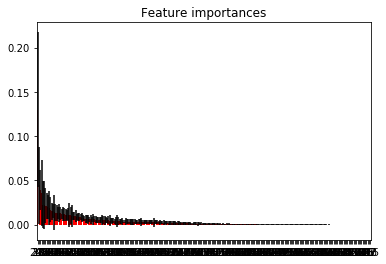

1. feature 32 (0.130005)
2. feature 243 (0.044240)
3. feature 238 (0.039566)
4. feature 98 (0.035817)
5. feature 107 (0.022575)
6. feature 76 (0.022413)
7. feature 91 (0.021481)
8. feature 104 (0.020507)
9. feature 70 (0.019955)
10. feature 11 (0.018632)
11. feature 264 (0.017018)
12. feature 47 (0.015088)
13. feature 23 (0.015034)
14. feature 92 (0.013961)
15. feature 109 (0.013490)
16. feature 54 (0.013486)
17. feature 12 (0.013276)
18. feature 86 (0.013001)
19. feature 63 (0.012677)
20. feature 99 (0.012374)
21. feature 112 (0.012132)
22. feature 27 (0.011459)
23. feature 162 (0.011128)
24. feature 42 (0.011032)
25. feature 3 (0.010996)
26. feature 2 (0.010728)
27. feature 262 (0.010429)
28. feature 64 (0.010033)
29. feature 100 (0.009873)
30. feature 210 (0.009828)
31. feature 255 (0.009780)
32. feature 78 (0.008624)
33. feature 132 (0.008554)
34. feature 226 (0.008397)
35. feature 4 (0.008100)
36. feature 68 (0.007814)
37. feature 73 (0.007493)
38. feature 126 (0.006799)
39. featu

In [25]:
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

import matplotlib.pyplot as plt
from numpy import std, argsort

importances = random_forest._clf.feature_importances_
std = std([tree.feature_importances_ for tree in random_forest._clf.estimators_],
             axis=0)
indices = argsort(importances)[::-1]

num_features = len(random_forest._clf.feature_importances_)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(num_features), indices)
plt.xlim([-1, num_features])
plt.show()

for f in range(num_features):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

#### Scikit Learn metrics: Confusion matrix, Classification report, F1 score, Log loss

http://scikit-learn.org/stable/modules/model_evaluation.html

In [26]:
from sklearn import metrics

def classification_report(predict, prob=True):
    predictions, labels = zip(*predict)
    if prob is True:
        return metrics.classification_report(labels, [p.max() for p in predictions])
    else:
        return metrics.classification_report(labels, predictions)

def confusion_matrix(predict, prob=True, print_layout=False):
    predictions, labels = zip(*predict)
    if print_layout is True:
        print('Layout\n[[tn   fp]\n [fn   tp]]\n')
    if prob is True:
        return metrics.confusion_matrix(labels, [p.max() for p in predictions])
    else:
        return metrics.confusion_matrix(labels, predictions)

def log_loss(predict):
    predictions, labels = zip(*predict)
    return metrics.log_loss(labels, [p.prob('pos') for p in predictions])

def roc_auc_score(predict):
    predictions, labels = zip(*predict)
    # need to convert labels to binary classification of 0 or 1
    return metrics.roc_auc_score([1 if l == 'pos' else 0 for l in labels], [p.prob('pos') for p in predictions], average='weighted')

In [27]:
print('SGD')
print(classification_report(sgd_predict))
print()
print('Logistic Regression')
print(classification_report(lr_predict))
print()
print('SVC')
print(classification_report(svc_predict))
print()
print('LinearSVC')
print(classification_report(linear_svc_predict, False))
print()
print('Random Forest')
print(classification_report(rf_predict))

SGD
             precision    recall  f1-score   support

        neg       0.90      0.75      0.82       472
        pos       0.78      0.91      0.84       446

avg / total       0.84      0.83      0.83       918


Logistic Regression
             precision    recall  f1-score   support

        neg       0.89      0.77      0.82       472
        pos       0.79      0.89      0.84       446

avg / total       0.84      0.83      0.83       918


SVC
             precision    recall  f1-score   support

        neg       0.85      0.77      0.81       472
        pos       0.78      0.86      0.82       446

avg / total       0.82      0.81      0.81       918


LinearSVC
             precision    recall  f1-score   support

        neg       0.89      0.78      0.83       472
        pos       0.79      0.90      0.84       446

avg / total       0.84      0.84      0.84       918


Random Forest
             precision    recall  f1-score   support

        neg       0.86      0.

In [28]:
print('Layout\n[[tn   fp]\n [fn   tp]]\n')

print('SGD')
print(confusion_matrix(sgd_predict))
print()
print('Logistic Regression')
print(confusion_matrix(lr_predict))
print()
print('SVC')
print(confusion_matrix(svc_predict))
print()
print('LinearSVC')
print(confusion_matrix(linear_svc_predict, False))
print()
print('Random Forest')
print(confusion_matrix(rf_predict))

Layout
[[tn   fp]
 [fn   tp]]

SGD
[[355 117]
 [ 39 407]]

Logistic Regression
[[363 109]
 [ 47 399]]

SVC
[[365 107]
 [ 63 383]]

LinearSVC
[[366 106]
 [ 43 403]]

Random Forest
[[367 105]
 [ 61 385]]


The lower the better for `log_loss`...

In [29]:
print(f'SGD: {log_loss(sgd_predict)}')
print(f'Logistic Regression: {log_loss(lr_predict)}')
print(f'SVC: {log_loss(svc_predict)}')
print(f'Random Forest: {log_loss(rf_predict)}')

SGD: 0.37847249143305395
Logistic Regression: 0.3731162798963883
SVC: 0.4150758412082994
Random Forest: 0.39579833325412017


The higher the better for `roc_auc_score`...

In [30]:
print(f'SGD: {roc_auc_score(sgd_predict)}')
print(f'Logistic Regression: {roc_auc_score(lr_predict)}')
print(f'SVC: {roc_auc_score(svc_predict)}')
print(f'Random Forest: {roc_auc_score(rf_predict)}')

SGD: 0.9158955308961009
Logistic Regression: 0.9168170935623623
SVC: 0.8879588812039219
Random Forest: 0.9088888044387019


*Note: We cannot compute `log_loss` or `roc_auc_score` for `LinearSVC` because it does not provide probability estimates.*

#### Performance on sample tasks

In [31]:
sample_tasks = ["Mow lawn", "Mow the lawn", "Buy new shoes", "Feed the dog", "Send report to Kyle", "Send the report to Kyle", "Peel the potatoes"]
features = [featurize(nlp(task)) for task in sample_tasks]

tasks_dummy = [(l, p.prob('pos')*1.0) for l, p in zip(dummy.classify_many(features), dummy.prob_classify_many(features))]
tasks_logistic = [(l, p.prob('pos')) for l,p in zip(logistic_regression.classify_many(features), logistic_regression.prob_classify_many(features))]
tasks_svc = [(l, p.prob('pos')) for l,p in zip(svc.classify_many(features), svc.prob_classify_many(features))]
tasks_linear_svc = linear_svc.classify_many(features)
tasks_sgd = [(l, p.prob('pos')) for l,p in zip(sgd.classify_many(features), sgd.prob_classify_many(features))]
tasks_rf = [(l, p.prob('pos')) for l,p in zip(random_forest.classify_many(features), random_forest.prob_classify_many(features))]

print(f'Dummy: {tasks_dummy}')
print(f'LogisticRegression: {tasks_logistic}')
print(f'SVC: {tasks_svc}')
print(f'LinearSVC: {tasks_linear_svc}')
print(f'SGD: {tasks_sgd}')
print(f'Random Forest: {tasks_rf}')

Dummy: [('neg', 0.0), ('neg', 0.0), ('neg', 0.0), ('neg', 0.0), ('pos', 1.0), ('neg', 0.0), ('pos', 1.0)]
LogisticRegression: [('pos', 0.59993632091708504), ('pos', 0.80545738462427463), ('pos', 0.90904984569308278), ('pos', 0.80545738462427463), ('pos', 0.85428416471513524), ('pos', 0.80545738462427463), ('pos', 0.82428633915248184)]
SVC: [('pos', 0.79790817731030483), ('pos', 0.74224643977964966), ('pos', 0.85309553545012395), ('pos', 0.74224643977964966), ('pos', 0.82893669789024926), ('pos', 0.74224643977964966), ('pos', 0.80199263468059634)]
LinearSVC: ['pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos']
SGD: [('pos', 0.59646047671669478), ('pos', 0.85159259765683115), ('pos', 0.93425820756426969), ('pos', 0.85159259765683115), ('pos', 0.90840726546647588), ('pos', 0.85159259765683115), ('pos', 0.86340530996514875)]
Random Forest: [('pos', 0.5399701926070386), ('pos', 0.92400000000000004), ('pos', 0.84232587787459112), ('pos', 0.92400000000000004), ('pos', 0.8786342592592592), ('pos'

_Note: `LinearSVC` is not implemented to provide probability estimates (https://github.com/scikit-learn/scikit-learn/issues/4820)_

## Next Steps and Improvements

1. Training set may be too specific/not relevant enough (recipe instructions for positive dataset, recipe descriptions+short movie reviews for negative dataset)
2. Throwing features into a blender - need to understand value of each
    - What feature "classes" tend to perform the best/worst?
    - [PCA](http://jotterbach.github.io/2016/03/24/Principal_Component_Analysis/): Reducing dimensionality using most informative feature information
3. Phrase vectorizations of all 0s - how problematic is this?
4. Varying feature vector lengths - does this matter?
5. Voting - POS taggers and classifiers
    - Ensembles (http://scikit-learn.org/stable/modules/ensemble.html)
6. Combining verb phrases
7. Cross validation, grid search
8. Look at examples from different quadrants of the confusion matrix - is there something we can learn?
    - Same idea with the classification report

---
# Things abandoned

## NLTK

I needed a library that supports dependency parsing, which NLTK does not... so I thought I'd add the [Stanford CoreNLP](https://stanfordnlp.github.io/CoreNLP/) toolkit and [its associated software](https://nlp.stanford.edu/software/) to NLTK. However, there are many conflicting instructions for installing the Java-based project, depending on NLTK version used. By the time I figured this out, the installation had become a time sink. So I abandoned this effort in favor of Spacy.io.

I might return this way if I want to improve results/implement a voter system between the various linguistic and classification methods later.

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

### Tokenization

In [ ]:
sentences = [s for l in lines for s in sent_tokenize(l)] # punkt
sentences

In [ ]:
tagged_sentences = []
for s in sentences:
    words = word_tokenize(s)
    tagged = nltk.pos_tag(words) # averaged_perceptron_tagger
    tagged_sentences.append(tagged)
print(tagged_sentences)

#### Note: POS accuracy

`Run down to the shop, will you, Peter` is parsed unexpectedly by `nltk.pos_tag`:
> `[('Run', 'NNP'), ('down', 'RB'), ('to', 'TO'), ('the', 'DT'), ('shop', 'NN'), (',', ','), ('will', 'MD'), ('you', 'PRP'), (',', ','), ('Peter', 'NNP')]`

`Run` is tagged as a `NNP (proper noun, singular)`

I expected an output more like what the [Stanford Parser](http://nlp.stanford.edu:8080/parser/) provides:
> `Run/VBG down/RP to/TO the/DT shop/NN ,/, will/MD you/PRP ,/, Peter/NNP`

`Run` is tagged as a `VGB (verb, gerund/present participle)` - still not quite the `VB` I want, but at least it's a `V*`

_MEANWHILE..._

`nltk.pos_tag` did better with:
> `[('Do', 'VB'), ('not', 'RB'), ('clean', 'VB'), ('soot', 'NN'), ('off', 'IN'), ('the', 'DT'), ('window', 'NN')]`

Compared to [Stanford CoreNLP](http://nlp.stanford.edu:8080/corenlp/process) (note that this is different than what [Stanford Parser](http://nlp.stanford.edu:8080/parser/) outputs):
> `(ROOT (S (VP (VB Do) (NP (RB not) (JJ clean) (NN soot)) (PP (IN off) (NP (DT the) (NN window))))))`

Concern: _clean_ as `VB (verb, base form)` vs `JJ (adjective)` 

**IMPROVE** POS taggers should vote: nltk.pos_tag (averaged_perceptron_tagger), Stanford Parser, CoreNLP, etc.

Note what Spacy POS tagger did with `Run down to the shop, will you Peter`:

`Run/VB down/RP to/IN the shop/NN ,/, will/MD you/PRP ,/, Peter/NNP`

    where `Run` is the `VB` I expected from POS tagging (compared to `nltk.pos_tag` result of `NNP`). Also note that Spacy collapses `the shop` into a single unit, which should be helpful during featurization.

### Featurization

In [ ]:
import re
from collections import defaultdict

featuresets = []
for ts in tagged_sentences:
    s_features = defaultdict(int)
    for idx, tup in enumerate(ts):
        #print(tup)
        pos = tup[1]
        # FeatureName.VERB
        is_verb = re.match(r'VB.?', pos) is not None
        print(tup, is_verb)
        if is_verb:
            s_features[FeatureName.VERB] += 1
            # FOLLOWING_POS
            next_idx = idx + 1;
            if next_idx < len(ts):
                s_features[f'{FeatureName.FOLLOWING}_{ts[next_idx][1]}'] += 1
            # VERB_MODIFIER
            # VERB_MODIFYING
        else:
            s_features[FeatureName.VERB] = 0
    featuresets.append(dict(s_features))

print()
print(featuresets)

### [Stanford NLP](https://nlp.stanford.edu/software/)
Setup guide used: https://stackoverflow.com/a/34112695

In [ ]:
# Get dependency parser, NER, POS tagger
!wget https://nlp.stanford.edu/software/stanford-parser-full-2017-06-09.zip
!wget https://nlp.stanford.edu/software/stanford-ner-2017-06-09.zip
!wget https://nlp.stanford.edu/software/stanford-postagger-full-2017-06-09.zip
!unzip stanford-parser-full-2017-06-09.zip
!unzip stanford-ner-2017-06-09.zip
!unzip stanford-postagger-full-2017-06-09.zip

In [ ]:
from nltk.parse.stanford import StanfordParser
from nltk.parse.stanford import StanfordDependencyParser
from nltk.parse.stanford import StanfordNeuralDependencyParser
from nltk.tag.stanford import StanfordPOSTagger, StanfordNERTagger
from nltk.tokenize.stanford import StanfordTokenizer